# Note that this is my 2nd 3rd submission. I have made the following changes
1. Removed speed. Speed is distance/time. Since time is the value we are predicting, I should not be including it. I understood my mistake now.
2. pickup_hour has been split into 6 parts and I have performed one-hot encoding.
3. I have done a grid-search and updated the best hyperparameters into the model.
4. Best Hyperparameters: 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200

In [256]:




%matplotlib inline
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [257]:
df = pd.read_csv('nyc_taxi_trip_duration 5.csv')

In [258]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)


In [259]:
import geopy
from  geopy.distance import geodesic

def get_distance(row):
    coords_1 = (row["pickup_latitude"], row["pickup_longitude"])
    coords_2 = (row["dropoff_latitude"], row["dropoff_longitude"])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Apply the function to each row and create a new column
df["distance"] = df.apply(get_distance, axis=1)

In [260]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,1.199770
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,4.123945
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,7.250436
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,2.358287
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,4.328155


In [261]:
df["day_of_week"] = df["pickup_datetime"].dt.day_name()

In [262]:
df.day_of_week=df.day_of_week.astype('category')
df.store_and_fwd_flag=df.store_and_fwd_flag.astype('category')
df.vendor_id=df.vendor_id.astype('category')
df.dtypes

id                            object
vendor_id                   category
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag          category
trip_duration                  int64
distance                     float64
day_of_week                 category
dtype: object

In [263]:
#Convert the Pick Up Hour into 6 hr divisions and doing onehot encoding


df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour

df['pickup_hour'] = (df['pickup_hour']//4)+1


In [265]:

mean_trip_duration = df['trip_duration'].mean()
std_trip_duration = df['trip_duration'].std()

# Calculate the threshold for outliers (mean ± 3 * standard deviation)
upper_limit = mean_trip_duration + 3 * std_trip_duration
#lower_limit = mean_trip_duration - 3 * std_trip_duration

# Replace outliers that are greater than the upper limit or lower than the lower limit
df['trip_duration'] = np.where(df['trip_duration'] > upper_limit, upper_limit, df['trip_duration'])


In [266]:
df.dtypes

id                            object
vendor_id                   category
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag          category
trip_duration                float64
distance                     float64
day_of_week                 category
pickup_hour                    int32
dtype: object

In [267]:
df = pd.get_dummies(df, columns=['vendor_id', 'pickup_hour', 'store_and_fwd_flag', 'day_of_week'], drop_first=False)


In [268]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1)


In [269]:
df.dtypes

passenger_count            int64
trip_duration            float64
distance                 float64
vendor_id_1                 bool
vendor_id_2                 bool
pickup_hour_1               bool
pickup_hour_2               bool
pickup_hour_3               bool
pickup_hour_4               bool
pickup_hour_5               bool
pickup_hour_6               bool
store_and_fwd_flag_N        bool
store_and_fwd_flag_Y        bool
day_of_week_Friday          bool
day_of_week_Monday          bool
day_of_week_Saturday        bool
day_of_week_Sunday          bool
day_of_week_Thursday        bool
day_of_week_Tuesday         bool
day_of_week_Wednesday       bool
dtype: object

In [281]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#df['trip_duration_log'] = np.log1p(df['trip_duration']) 



scaler = MinMaxScaler()

df['distance'] = scaler.fit_transform(df[['distance']])
df['passenger_count'] = scaler.fit_transform(df[['passenger_count']])

X = df.drop('trip_duration', axis=1)  # Features


y = df['trip_duration']  # Target (trip duration)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model (using Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set

y_pred = model.predict(X_test)
y_pred_train=model.predict(X_train)
# Reverse log transformation to get the original scale of 'trip_duration'

# Calculate RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE test: {rmse}")


r2_test = r2_score(y_test, y_pred)
print(f"R² score test: {r2_test}")

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print(f"RMSE train: {rmse_train}")


r2_train = r2_score(y_train, y_pred_train)
print(f"R² score train: {r2_train}")

RMSE test: 454.69063264071696
R² score test: 0.5687565571480834
RMSE train: 441.8820426107753
R² score train: 0.490447904566247


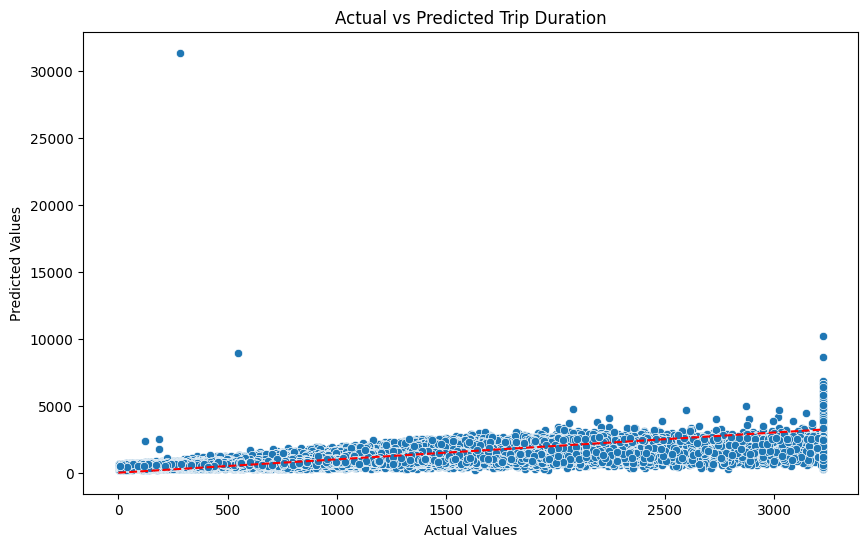

In [282]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for positive values
mask = (y_test > 0) & (y_pred > 0)
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred[mask]

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_filtered, y=y_pred_filtered)
plt.plot([0, y_test_filtered.max()], [0, y_test_filtered.max()], color='red', linestyle='--')
plt.title('Actual vs Predicted Trip Duration')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


In [292]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(max_depth=20, max_features= 'sqrt', min_samples_leaf= 4, min_samples_split= 10, n_estimators= 200)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_train = rf_model.predict(X_train)

# Calculate RMSE


Random Forest RMSE: 344.92337334609937
Random Forest RMSE Training: 304.2774396628448


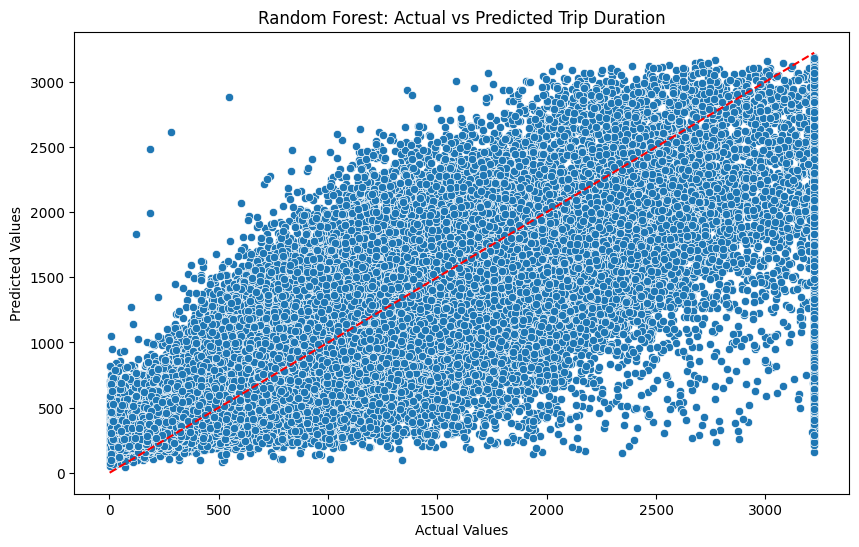

In [293]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf}")
rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
print(f"Random Forest RMSE Training: {rmse_rf_train}")

y_pred_rf = np.maximum(y_pred_rf, 0)

# Optionally plot the predicted vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Random Forest: Actual vs Predicted Trip Duration')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [294]:
r2 = r2_score(y_test, y_pred_rf)
print(f"R² score test: {r2}")

r2_train = r2_score(y_train, y_pred_rf_train)
print(f"R² score train: {r2_train}")

R² score test: 0.6896649425979342
R² score train: 0.7583897289277741


In [286]:
df.dtypes

passenger_count          float64
trip_duration            float64
distance                 float64
vendor_id_1                 bool
vendor_id_2                 bool
pickup_hour_1               bool
pickup_hour_2               bool
pickup_hour_3               bool
pickup_hour_4               bool
pickup_hour_5               bool
pickup_hour_6               bool
store_and_fwd_flag_N        bool
store_and_fwd_flag_Y        bool
day_of_week_Friday          bool
day_of_week_Monday          bool
day_of_week_Saturday        bool
day_of_week_Sunday          bool
day_of_week_Thursday        bool
day_of_week_Tuesday         bool
day_of_week_Wednesday       bool
dtype: object

In [287]:
df['distance'].max()
df['distance'].min()

0.0

In [288]:
df['distance'].max()

1.0

In [289]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],  # Number of trees
    'max_depth': [10, 20, None],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf node
    'max_features': ['auto', 'sqrt']  # Number of features to consider at each split
}

# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Predict using the best estimator
y_pred_rf = best_rf.predict(X_test)
y_pred_rf_train = best_rf.predict(X_train)

# Calculate RMSE and R2 for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_test = r2_score(y_test, y_pred_rf)

# Calculate RMSE and R2 for the training set (optional to check overfitting)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
r2_train = r2_score(y_train, y_pred_rf_train)

# Print the best hyperparameters, R2, and RMSE for the best model
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Test Set RMSE: {rmse_test}")
print(f"Test Set R²: {r2_test}")
print(f"Training Set RMSE: {rmse_train}")
print(f"Training Set R²: {r2_train}")

# Print RMSE and R² for each parameter combination
cv_results = grid_search.cv_results_

for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    rmse = np.sqrt(-mean_score)  # Since GridSearchCV minimizes -MSE
    print(f"Params: {params} | RMSE: {rmse:.4f} | R²: {r2_test:.4f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimato